# Colab Setup

In [1]:
# Check GPU availability
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)


(True, 'NVIDIA L4')

In [6]:
# Remove old clone
import os, shutil

repo_name = "ANeurIPS2024_SPV-MIA"
if os.path.basename(os.getcwd()) == repo_name:
    %cd ..
if os.path.exists(repo_name):
    print(f"Removing existing {repo_name}...")
    shutil.rmtree(repo_name)

# Clone fork
!git clone https://github.com/Varzz04/ANeurIPS2024_SPV-MIA.git
%cd ANeurIPS2024_SPV-MIA


/content
Removing existing ANeurIPS2024_SPV-MIA...
Cloning into 'ANeurIPS2024_SPV-MIA'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 61 (delta 18), reused 25 (delta 12), pack-reused 25 (from 1)
Receiving objects: 100% (61/61), 725.78 KiB | 27.91 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/ANeurIPS2024_SPV-MIA


In [7]:
!pip install -r requirements-colab.txt

In [8]:
!pip show transformers

Name: transformers
Version: 4.51.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers, trl


# Target Model Fine-tuning

In [9]:
# Launch fine-tuning test using a smaller falcon model and small wikitext-2-raw-v1 slice
!accelerate launch ./ft_llms/llms_finetune.py \
--output_dir ./ft_llms/falcon/wikitext/target/ \
--block_size 128 --eval_steps 100 --save_epochs 100 --log_steps 100 \
-d wikitext -m tiiuae/falcon-rw-1b --packing --use_dataset_cache \
-e 2 -b 2 -lr 1e-4 --gradient_accumulation_steps 1 \
--train_sta_idx=0 --train_end_idx=2000 --eval_sta_idx=0 --eval_end_idx=500 \
--dataset_config_name wikitext-2-raw-v1


The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-05-05 18:15:22.517448: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 18:15:22.534501: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746468922.555794    4068 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register 

# Self-prompt Reference Model Fine-tuning

In [10]:
!accelerate launch ./ft_llms/refer_data_generate.py \
-tm ./ft_llms/falcon/wikitext/target/ \
-m tiiuae/falcon-rw-1b -d wikitext \
--dataset_config_name wikitext-2-raw-v1


A streamkimeneten csak az utolsó 5000 sor látható.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
tensor(2.4453, device='cuda:0', grad_fn=<NllLossBackward0>)
 75% 4920/6585 [2:59:27<1:00:21,  2.18s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
tensor(2.5561, device='cuda:0', grad_fn=<NllLossBackward0>)
 75% 4921/6585 [2:59:29<1:00:29,  2.18s/it]The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
tensor(2.6077, device='cuda:0', grad_fn=<NllLossBackward0>)
 75% 4922/6585 [2:59:32<1:00:21,  2.18s/it]The attention mask and the pad token id were not set. As a consequence, you ma

In [11]:
!accelerate launch ./ft_llms/llms_finetune.py --refer \
--output_dir ./ft_llms/falcon/wikitext/refer/ \
--block_size 128 --eval_steps 100 --save_epochs 100 --log_steps 100 \
-d wikitext -m tiiuae/falcon-rw-1b --packing --use_dataset_cache \
-e 2 -b 2 -lr 5e-5 --gradient_accumulation_steps 1 \
--train_sta_idx=0 --train_end_idx=2000 --eval_sta_idx=0 --eval_end_idx=500 \
--dataset_config_name wikitext-2-raw-v1

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-05-05 22:28:35.219092: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 22:28:35.236218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746484115.257395   66063 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register 

# Run SPV-MIA

In [13]:
!python attack.py

2025-05-05 22:42:34.944682: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 22:42:34.960977: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746484954.982030   69665 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746484954.988470   69665 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-05 22:42:35.009345: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

<ipython-input-17-791e3dee5835>:11: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  plt.plot(fpr, tpr, label=f'ROC curve (AUC = {np.round(np.trapz(tpr, fpr), 4)})')


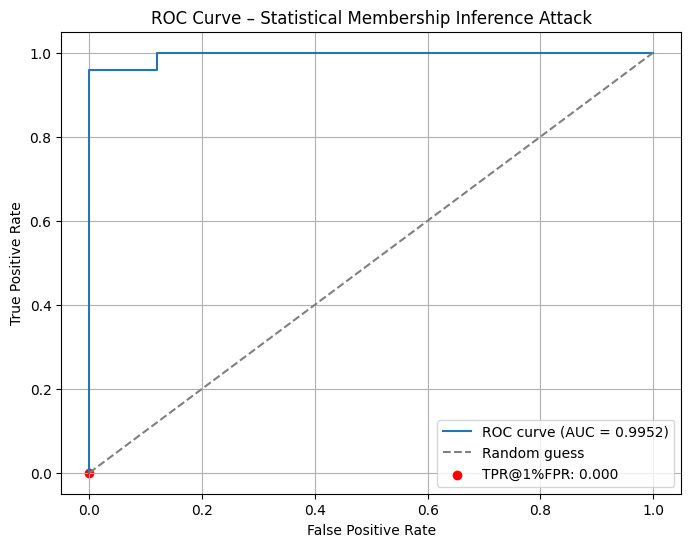

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Load ROC curve data
data = np.load("/content/ANeurIPS2024_SPV-MIA/cache/wikitext/wikitext-2-raw-v1/attack_data_tiiuae/falcon-rw-1b@wikitext/roc_stat.npz")
fpr = data["fpr"]
tpr = data["tpr"]

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {np.round(np.trapz(tpr, fpr), 4)})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Statistical Membership Inference Attack")
plt.legend()
plt.grid(True)

# Mark TPR@1%FPR
fpr_1_index = np.argmin(np.abs(fpr - 0.01))
plt.scatter(fpr[fpr_1_index], tpr[fpr_1_index], color='red', label=f'TPR@1%FPR: {tpr[fpr_1_index]:.3f}')
plt.legend()

# Save the figure
plt.savefig("roc_stat.png", dpi=300)
plt.show()
